# PyTorch에서의 이미지와 로지스틱 회귀

### "Deep Learning with Pytorch: Zero to GANs"의 3번째 파트

이 튜토리얼은 [PyTorch](https://pytorch.org)를 이용한 초보자용 딥러닝 학습 튜토리얼 입니다.   
학습하기 위한 최고의 방법은 본인이 코드를 실행하고, 실험해 보는 것이기 때문에 이 튜토리얼은 실용성과 코딩 중심으로 진행됩니다.


이번 튜토리얼에선 다음과 같은 주제를 다룹니다:
    
>* PyTorch에서의 __이미지 작업 (MNIST 데이터셋을 사용)__
>* __학습, 검증 및 테스트 세트__ 로 데이터셋 분할
>* `nn.Module` 클래스를 확장하여 커스텀 로직으로 PyTorch 모델을 생성합니다.
>* __Softmax__ 를 사용하여 모델 출력을 __확률로 해석__ 하고 예측된 레이블 선택
>* 분류 문제를 위한 유용한 __평가 지표(정확도)__ 와 __손실 함수(교차 엔트로피)__ 를 선정
>* 검증 세트를 사용하여 모델을 평가하는 교육 루프 설정
>* 무작위로 선택한 예제에 대해 수동으로 모델 테스트
>* 모델 체크포인트 저장 및 로딩으로 처음부터 재교육 하는 것을 방지

---
## 이미지 작업

>이 튜토리얼에서, 저희는 PyTorch에 대한 기본 지식과 선형 회귀를 사용해 __이미지 분류__ 라는 색다른 종류의 문제를 풀어볼 것입니다.<br>
저희는 [MNIST 손글씨 숫자 데이터베이스](http://yann.lecun.com/exdb/mnist/)를 사용할 것입니다. <br>
__<font color=blue>MNIST 데이터 셋</font>__ 은 28×28(pixel) 흑백 손글씨 숫자 이미지와 각 이미지가 나타내는 숫자의 레이블로 구성되어 있습니다.<br>
아래 그림은 MNIST 데이터 셋의 샘플 이미지들 입니다:

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

`torch`와 `torchvision`을 설치하고 import 하는것으로 시작합니다. <br>
`torchvision`은 이미지 작업을 위한 몇 가지 유틸리티가 포함되어 있고, MNIST와 같은 유명한 데이터 셋을 자동으로 다운로드하고 가져올수 있는 클래스 또한 제공합니다.

In [1]:
# 필요한 경우 주석 처리를 제거하고 여러분의 운영 체제에 적합한 명령을 실행하시면 됩니다.

# Linux / Binder
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib torch torchvision torchaudio

In [2]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST

In [3]:
# 학습 데이터 셋 다운로드
dataset = MNIST(root='./data/', download=True)

100.1%

Extracting ./data/MNIST\raw\train-images-idx3-ubyte.gz to ./data/MNIST\raw


0.0%

Extracting ./data/MNIST\raw\train-labels-idx1-ubyte.gz to ./data/MNIST\raw


180.4%C:\Miniconda3\envs\gan\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/MNIST\raw
Extracting ./data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/MNIST\raw
Processing...
Done!


위 코드가 처음 실행되면 노트북과 같은 폴더 내에 있는 `data/` 디렉토리에 데이터를 다운로드하고 PyTorch `Dataset`을 생성합니다.<br>
이후 실행에서는 데이터가 이미 다운로드 되었기 때문에 다운로드를 건너뛰게 됩니다.<br>
이제 데이터셋의 크기를 확인해 보겠습니다.

In [4]:
len(dataset)

60000

__MNIST__ <br>
>받은 데이터 셋에는 모델을 교육하는데 사용할 60000개의 이미지가 있고,<br>
아래 셀에서 확인할 것이지만 모델 평가에 사용될 10000개의 테스트 데이터가 있습니다.<br>
`train=False`를 생성자에게 전달해 __MNIST__ 데이터의 테스트 데이터 셋을 생성할 수 있습니다.

In [5]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

학습 데이터 셋으로부터 샘플 요소를 보겠습니다.

In [6]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x21B2A8B1100>, 5)

위에서 보이듯이 데이터는 28×28px 이미지와 레이블로 구성되어 있습니다.<br>
이미지는 클래스 `PIL.Image.Image`의 객체로 이 객체는 Python 이미지 라이브러리 [Pillow](https://pillow.readthedocs.io/en/stable/)의 요소입니다.<br>
저희는 [`matplotlib`](https://matplotlib.org/)을 이용해 이미지를 주피터 노트북에서 시각화 할 수 있습니다.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

`%matplotlib inline`이라는 코드는 주피터에게 그래프를 노트북 내에서 그리고 싶다는 것을 알려주는 코드입니다.<br>
`%`로 시작하는 코드는 _magic commands_ 라 부르며 주피터의 동작을 제어하는데 사용됩니다.<br>
_magic commands_ 에 대한 전체 내용은 다음 링크에서 찾을 수 있습니다: https://ipython.readthedocs.io/en/stable/interactive/magics.html <br>
데이터셋의 몇가지 이미지를 확인해 보겠습니다.

Label: 5


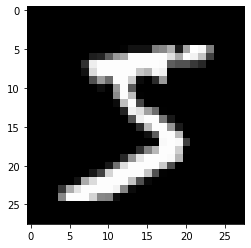

In [8]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 3


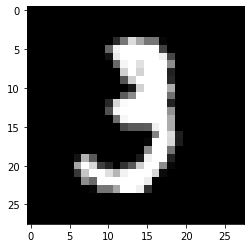

In [9]:
image, label = dataset[10]
plt.imshow(image, cmap='gray')
print('Label:', label)

이미지들은 상대적으로 작으며, 숫자를 인식하는 것이 때로는 사람의 눈으로도 어려울 수 있습니다. <br>
이러한 이미지를 보는 것은 쓸모가 있지만, _PyTorch_ 는 이미지를 어떻게 처리할지를 모른다는 문제점이 존재합니다. <br>
그래서 저희는 __이미지를 텐서로 변환__ 할 필요가 있습니다.<br>
저희는 `transforms`를 사용해 데이터셋을 텐서로 변환이 가능합니다. <br>

In [10]:
import torchvision.transforms as transforms

PyTorch의 데이터 셋을 사용하면 로드될때 이미지에 적용할 변환 기능을 한 가지 이상 지정 가능합니다.<br>
`torchvision.transforms` 모듈은 많은 미리 정의된 함수들을 포함하고 있습니다.<br>
저희는 `ToTensor` 변환으로 이미지를 PyTorch 텐서로 바꿀 수 있습니다.

In [11]:
# MNIST 데이터 셋 (이미지와 레이블)
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [12]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


이제 이미지는 1×28×28 텐서로 변환됩니다. <br>
첫번째 차원은 __색상의 채널__ 을 의미하고, 두번째와 세번째 차원은 __이미지의 height와 width의 픽셀__ 을 의미합니다. <br>
MNIST 데이터셋은 흑백 이미지이기 때문에 1개의 색상 채널을 가지게 됩니다.<br>
다른 데이터셋들은 컬러 이미지로 되어있고, 이 경우 <font color=red>빨강</font>, <font color=green>초록</font>, <font color=blue>파랑</font>(RGB)로 3가지의 채널을 갖게 됩니다.

몇몇 샘플 값을 확인해 보겠습니다.

In [13]:
print(img_tensor[0,10:15,10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


값의 범위는 0~1이고 `0`은 검정, `1` 흰색, 그리고 사잇 값은 회색을 가집니다. <br>
또한 `plt.imshow`를 사용해 텐서를 이미지로 표시할 수 있습니다.

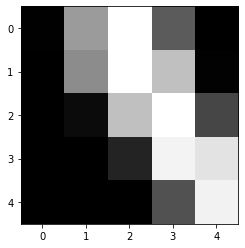

In [14]:
# 28x28 행렬을 전달하여 이미지를 플로팅
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray');

채널 차원 없이 28×28 행렬을 `plt.imshow`로 전달하면 됩니다. <br>
이때 회색조 이미지를 표시하기 위해 `cmap=gray`으로 설정합니다.

## 학습과 검증 데이터셋

실제 기계 학습 모델을 구축하는 동안 데이터 세트를 세 부분으로 분할하는 것이 매우 일반적입니다.
>1. **Training set** - 모델을 훈련시키는 데 사용되는 데이터 셋<br>
 = 즉, 손실 계산과 경사 하강을 사용해 모델의 가중치를 조정합니다.
>2. **Validation set** - 학습 도중 모델을 평가하는데 사용되는 데이터 셋<br>
 = 하이퍼 파라미터를 조정하고, 최적의 모델을 선택하게 합니다.
>3. **Test set** - 다른 모델이나 접근법들과 비교하기 위해 사용되는 데이터 셋<br>
 = 모델의 최종 정확도를 나타냅니다.

MNIST 데이터 셋에는 60000개의 학습 이미지와 10000개의 테스트 이미지들이 있습니다. <br>
테스트 셋은 서로 다른 연구자들이 동일한 이미지 셋에 대해 모델 결과(성능)를 보고할 수 있도록 표준화되었습니다.

미리 정의된 검증 셋이 없으므로 60000개의 이미지를 훈련 및 검증 데이터 셋으로 수동으로 분할해야 합니다.<br>
PyTorch의 `random_split` 메서드를 사용해 10000개를 무작위로 뽑아 검증 셋으로 만듭니다.

In [15]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

검증 세트를 생성하기 위해 무작위 샘플을 선택하는 것이 중요합니다. <br>
학습 데이터는 종종 타겟 레이블에 의해 정렬됩니다. (0 이미지 뒤에 1 이미지, 그 뒤에 2 이미지...)<br>
만약 마지막 20%의 이미지를 사용해 검증 셋을 생성하는 경우 검증 셋은 8과 9로만 구성됩니다.<br>
반면 훈련 데이터에는 8과 9가 포함되지 않습니다. <br>
그러한 훈련 검증은 유용한 모델을 훈련시키는 것이 거의 불가능합니다. <br>
그러므로 검증 세트는 무작위 샘플을 선택하는 것이 중요합니다.

이제 데이터를 배치 단위로 로드하기 위해 데이터 로더를 생성합니다. 배치 사이즈를 여기서는 128로 정의하겠습니다.

In [16]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

`shuffle=True`로 설정해 학습 데이터 로더가 매 epoch마다 배치가 다르게 생성되게 됩니다. <br>
이러한 무작위화는 __학습 과정을 일반화__ 하고 __학습 속도를 높이는데 도움__ 이 됩니다. <br>
반면, 검증 데이터 로더는 모델을 평가하는데만 사용되기 때문에, 이미지를 __섞을 필요가 없습니다__.

## Model

이제 데이터 로더가 준비되었으므로 모델을 정의할 차례입니다.

* __로지스틱 회귀__ 는 선형 회귀 모델과 거의 동일합니다. 로지스틱 회귀는 가중치와 편향 행렬을 가지고, 출력은 `pred = x @ w.t() + b`라는 간단한 행렬 연산으로 얻어질 수 있습니다.

* 선형 회귀에서 했던 것처럼, 직접 클래스를 정의하고 행렬을 초기화 하는것 대신 `nn.Linear`를 사용해 모델을 정의 할 수 있습니다.

* `nn.Linear`는 __입력 데이터가 벡터__ 이어야 합니다. 각 1×28×28 이미지 텐서는 784크기(28×28) 벡터로 _평탄화_ 되어 모델에 입력으로 들어갑니다. (_평탄화_ 란 다차원 행렬을 1차원으로 바꾸는 것을 의미합니다.)

* 각 이미지의 출력 벡터는 10의 사이즈를 가지고, 각 요소는 벡터의 인덱스에 따라 레이블의 확률이 됩니다.(즉, 0~9) 

* 결과적으로 이미지의 예측된 레이블은 전체 레이블중 <font color=red>가장 확률이 높은 것</font>으로 선택됩니다.

In [17]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)

이 모델은 파라미터 수 측면에서 이전 모델보다 훨씬 큽니다.<br>
모델의 가중치와 편향에대해 살펴보도록 하겠습니다.

In [18]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-0.0275,  0.0045,  0.0095,  ..., -0.0110, -0.0214,  0.0202],
        [ 0.0155, -0.0018,  0.0339,  ..., -0.0199, -0.0248,  0.0255],
        [-0.0277,  0.0328,  0.0155,  ..., -0.0088,  0.0280,  0.0167],
        ...,
        [ 0.0102,  0.0204,  0.0136,  ..., -0.0291, -0.0247, -0.0252],
        [-0.0079, -0.0011, -0.0044,  ..., -0.0002, -0.0040,  0.0297],
        [ 0.0186, -0.0315,  0.0253,  ...,  0.0304, -0.0286, -0.0340]],
       requires_grad=True)

In [19]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([-0.0318, -0.0089,  0.0216, -0.0189,  0.0040,  0.0262, -0.0147, -0.0310,
         0.0289, -0.0176], requires_grad=True)

비록 전체 파라미터 수가 7850(10×784+10)으로 많이 이전보다 훨씬 커졌지만, __개념적으로 달라진것은 없습니다__. <br>
이제 이 모델로 출력을 생성해 보도록 하겠습니다.<br>
데이터 셋으로부터 128개의 첫 이미지 배치를 가져와 모델에 넣어 학습시킬 것입니다.

In [20]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images.reshape(-1,784))
    print(outputs)
    break

tensor([1, 1, 7, 2, 0, 8, 3, 7, 2, 9, 7, 1, 2, 5, 8, 2, 0, 3, 5, 1, 3, 4, 1, 2,
        2, 2, 7, 4, 5, 1, 5, 8, 6, 5, 7, 2, 7, 9, 1, 8, 7, 0, 4, 8, 3, 8, 4, 9,
        1, 7, 0, 7, 0, 1, 2, 5, 0, 5, 7, 2, 9, 4, 1, 7, 6, 8, 8, 2, 1, 3, 1, 5,
        2, 9, 7, 3, 8, 3, 3, 7, 1, 3, 3, 4, 4, 3, 5, 7, 6, 9, 0, 6, 1, 1, 7, 7,
        2, 8, 6, 0, 0, 9, 7, 3, 9, 7, 1, 8, 4, 0, 3, 9, 7, 3, 3, 5, 3, 6, 3, 7,
        9, 9, 0, 7, 0, 5, 7, 6])
torch.Size([128, 1, 28, 28])
tensor([[-0.1461, -0.0155, -0.1319,  ..., -0.0132, -0.0552, -0.1762],
        [-0.0178,  0.0994, -0.0302,  ..., -0.0284, -0.1550, -0.1671],
        [-0.0850, -0.4022, -0.2754,  ..., -0.0492, -0.0176, -0.1439],
        ...,
        [-0.0324, -0.1497, -0.1170,  ...,  0.0723, -0.0928, -0.1417],
        [ 0.0606, -0.0976, -0.0776,  ...,  0.0105, -0.0637,  0.1281],
        [-0.3025, -0.2155, -0.0163,  ..., -0.2034, -0.2099, -0.1541]],
       grad_fn=<AddmmBackward>)


In [21]:
images.shape

torch.Size([128, 1, 28, 28])

In [22]:
images.reshape(128, 784).shape

torch.Size([128, 784])

저희의 입력 데이터가 __적절한 형태(shape)__ 가 아니기 때문에 위의 코드는 오류를 일으킵니다.<br>
MNIST 이미지의 형태(shape)는 1×28×28이지만, 모델은 784 사이즈의 벡터를 입력으로 받을 수 있습니다.<br>
즉, 이 이미지를 벡터로 _평탄화_ 시켜야만 합니다.<br>
텐서의 `.reshape` 메서드를 사용해 텐서의 shape를 변환 할 수 있습니다.<br>
이 방법으로 각 이미지를 복사하지 않고도 벡터로 만들 수 있습니다.<br>
모델에 이러한 추가 기능을 모델에 포함시키기 위해, PyTorch의 `nn.Module`을 사용해 커스텀 모델을 만들 수 있습니다.

Python의 클래스는 객체를 생성하기 위한 __"청사진"(설계도)__ 를 제공합니다.<br>
Python의 새로운 클래스를 정의하는 한가지 예시를 보도록 하겠습니다.

In [23]:
class Person:
    # 클래스 생성자
    def __init__(self, name, age):
        # 객체 속성
        self.name = name
        self.age = age
    
    # 메서드
    def say_hello(self):
        print("Hello my name is " + self.name + "!")

아래 코드는 `Person`클래스의 인스턴스를 생성하는 방법입니다.

In [24]:
bob = Person("Bob", 32)

객체 `bob`은 `Person`클래스의 인스턴스입니다.

저희는 객체의 속성이라 불리는 요소들에 접근이 가능하고, `.`을 이용해 객체 내 함수를 호출 가능합니다.

In [25]:
bob.name, bob.age

('Bob', 32)

In [26]:
bob.say_hello()

Hello my name is Bob!




Python 클래스에 대해 더 알고싶다면 다음 링크를 참조하시길 바랍니다:
https://www.w3schools.com/python/python_classes.asp .

클래스들은 이미 존재하는 클래스를 상속받아 해당 클래스의 함수들을 사용 및 수정 할 수 있습니다.<br>
PyTorch의 `nn.Module`클래스를 상속한 커스텀 모델을 정의해 보겠습니다.

In [27]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MnistModel()

`__init__` 생성자 메서드안에 `nn.Linear`를 사용해 가중치와 편향을 인스턴스화 하였고, `forward` 메서드 안에서 입력 텐서를 _평탄화_ 하여 `self.linear`에 넣어주게 정의 하였습니다.<br>
이때 `forward`함수는 모델에 __입력 배치를 넘겨줄때 호출__되는 함수입니다.

`xb.reshape(-1, 28×28)`은 `xb` 텐서를 2개의 차원으로 *볼 것*이라는 것을 나타냅니다.<br>
2번째 차원의 길이는 28×28 (즉, 784)입니다.<br>
`.reshape`에 `-1`이라는 값을 파라미터로 넣어줄 수 있습니다.(위의 경우 첫번째 차원에 넣어줌) <br>
이것은 원본 텐서의 형태를 기반으로 나머지 차원의 길이를 전부 계산하고 <font color=blue>남은 값</font>을 PyTorch가 자동적으로 계산에 넣는 것을 의미합니다. (위의 경우 본래 입력의 형태가 128×28×28이었으므로 -1에 들어갈 값은 128이 됩니다.)

모델은 더이상 `.weight`와 `.bias`라는 속성을 __가지지 않는다__ 는 것에 유의하시길 바랍니다. <br>
하지만 `.parameters` 메서드를 가지고 있어 가중치와 편향을 포함한 리스트를 반환 할 수 있습니다.


In [28]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [29]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[ 0.0191,  0.0054, -0.0010,  ...,  0.0149,  0.0239, -0.0308],
         [ 0.0257, -0.0265,  0.0069,  ..., -0.0283,  0.0341, -0.0010],
         [-0.0140,  0.0107,  0.0008,  ..., -0.0257,  0.0247,  0.0309],
         ...,
         [-0.0250,  0.0299,  0.0129,  ...,  0.0244,  0.0326, -0.0014],
         [-0.0087,  0.0179,  0.0285,  ...,  0.0111,  0.0111,  0.0097],
         [ 0.0055, -0.0188, -0.0246,  ...,  0.0297,  0.0201,  0.0311]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0240, -0.0329, -0.0190, -0.0057, -0.0070,  0.0201,  0.0009, -0.0138,
          0.0093,  0.0093], requires_grad=True)]

이렇게 새로 만들어진 모델은 이전과 같은 방식으로 사용이 가능합니다.<br>
어떻게 작동하는지 보도록 하겠습니다.<br>

In [30]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([128, 1, 28, 28])
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.3383, -0.0948, -0.0769, -0.2892, -0.2515,  0.0432,  0.3226, -0.2827,
          0.3245,  0.4963],
        [-0.2515, -0.2931,  0.0445, -0.0281, -0.2712,  0.1678,  0.2103, -0.1305,
          0.2924,  0.0345]])


100개의 입력 이미지 각각에 대해 타겟 클래스당 하나씩 10개의 출력을 제공합니다.<br>
앞서 설명한 바와 같이, 이러한 결과물이 <font color=blue>확률</font>을 나타내기를 원합니다. <br>
각 출력 행의 요소는 __[0,1]__ 의 범위를 만족해야 합니다.

출력 행을 확률로 변환하기 위해 아래 그림에서 설명하는 소프트맥스 함수를 사용합니다.

![softmax](https://i.imgur.com/EAh9jLN.png)

첫째로, 출력행의 각 요소 `yi`를 `e^y`로 대체해 모든 요소를 <font color=red>양수</font>로 만듭니다.

![](https://www.montereyinstitute.org/courses/DevelopmentalMath/COURSE_TEXT2_RESOURCE/U18_L1_T1_text_final_6_files/image001.png)


그 후 각 요소를 모든 요소의 합계로 나누어 __전체 요소의 합이 1__ 이 되도록 합니다.<br>
그 결과 각 요소는 __확률로 해석__ 될 수 있습니다.

소프트맥스 함수의 구현은 쉽지만(실제로 한번쯤은 구현해 보셔야 합니다!) 구현하는것 대신 PyTorch에서 제공하는 소프트맥스 함수를 사용할 것입니다.

In [31]:
import torch.nn.functional as F

소프트맥스 함수는 `torch.nn.functional` 패키지에 포함되어 있고, 이때 소프트맥스를 적용할 차원을 지정해야 합니다.

In [32]:
outputs[:2]

tensor([[-0.3383, -0.0948, -0.0769, -0.2892, -0.2515,  0.0432,  0.3226, -0.2827,
          0.3245,  0.4963],
        [-0.2515, -0.2931,  0.0445, -0.0281, -0.2712,  0.1678,  0.2103, -0.1305,
          0.2924,  0.0345]], grad_fn=<SliceBackward>)

In [33]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.0694, 0.0885, 0.0901, 0.0729, 0.0756, 0.1016, 0.1343, 0.0733, 0.1346,
         0.1598],
        [0.0780, 0.0748, 0.1048, 0.0975, 0.0765, 0.1186, 0.1237, 0.0880, 0.1343,
         0.1038]])
Sum:  1.0


마지막으로 각 출력 행에서 확률이 가장 높은 요소의 인덱스를 선택하는 것으로 각 이미지에 대한 예측 레이블을 결정할 수 있습니다.<br>
각 행의 가장 큰 요소와 해당 인덱스를 반환하는 `torch.max`를 사용해 이 작업을 수행 가능합니다.

In [34]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([9, 8, 5, 8, 0, 8, 5, 8, 8, 8, 8, 5, 8, 3, 9, 6, 6, 5, 5, 9, 8, 8, 2, 5,
        8, 5, 8, 6, 9, 8, 9, 8, 5, 8, 5, 9, 5, 8, 6, 6, 6, 8, 9, 8, 8, 5, 5, 9,
        5, 6, 8, 6, 9, 2, 8, 9, 5, 8, 5, 8, 8, 7, 9, 8, 8, 8, 8, 8, 5, 9, 5, 8,
        9, 8, 8, 8, 5, 6, 9, 8, 5, 5, 5, 6, 8, 6, 8, 8, 5, 2, 8, 6, 7, 8, 5, 9,
        5, 8, 5, 6, 5, 5, 5, 5, 5, 6, 9, 8, 8, 8, 5, 8, 8, 5, 6, 8, 8, 6, 5, 8,
        5, 6, 6, 8, 8, 8, 6, 7])
tensor([0.1598, 0.1343, 0.1270, 0.1313, 0.1247, 0.1324, 0.1448, 0.1232, 0.1208,
        0.1305, 0.1407, 0.1380, 0.1491, 0.1321, 0.1226, 0.1673, 0.1452, 0.1316,
        0.1268, 0.1564, 0.1450, 0.1541, 0.1457, 0.1338, 0.1468, 0.1409, 0.1761,
        0.1285, 0.1370, 0.1432, 0.1439, 0.1224, 0.1298, 0.1578, 0.1498, 0.1375,
        0.1324, 0.1428, 0.1387, 0.1329, 0.1447, 0.1430, 0.1227, 0.1313, 0.1658,
        0.1363, 0.1250, 0.1305, 0.1468, 0.1690, 0.1516, 0.1502, 0.1255, 0.1557,
        0.1331, 0.1465, 0.1349, 0.1488, 0.1322, 0.1577, 0.1538, 0.1188, 0.1495,
       

위 숫자는 학습 이미지의 첫 배치에 대한 예측 레이블입니다. <br>
실제 레이블과 비교해 보겠습니다.

In [35]:
labels

tensor([0, 8, 6, 4, 9, 1, 0, 4, 4, 8, 8, 8, 9, 2, 6, 0, 3, 7, 0, 0, 8, 9, 5, 1,
        3, 1, 7, 3, 9, 0, 6, 3, 7, 4, 2, 6, 7, 9, 0, 4, 8, 9, 3, 9, 2, 1, 1, 9,
        6, 0, 9, 3, 6, 6, 6, 6, 4, 6, 0, 8, 4, 9, 9, 7, 6, 9, 6, 2, 9, 6, 7, 7,
        9, 8, 0, 6, 8, 2, 3, 7, 1, 3, 1, 3, 2, 8, 1, 9, 8, 5, 6, 7, 3, 9, 1, 4,
        3, 3, 3, 3, 5, 1, 8, 1, 2, 7, 6, 8, 1, 7, 1, 8, 8, 8, 2, 5, 2, 3, 9, 0,
        0, 2, 0, 3, 1, 9, 3, 4])

예측된 라벨의 대부분은 실제 라벨과 다릅니다. <br>
그것은 우리가 __무작위로 초기화__ 된 가중치와 편향으로 예측을 했기 때문입니다.<br>
더 나은 예측을 얻기 위해선 _경사 하강법_ 을 사용해 가중치를 조정해 모델을 훈련 시켜야 합니다.

## 평가 메트릭과 손실 함수

선형 회귀때와 마찬가지로 모델이 얼마나 잘 작동하는지 __평가__ 할 수 있는 방법이 필요합니다. <br>
이를 위한 적절한 방법은 예측의 __정확도__ 입니다.

In [36]:
outputs[:2]

tensor([[-0.3383, -0.0948, -0.0769, -0.2892, -0.2515,  0.0432,  0.3226, -0.2827,
          0.3245,  0.4963],
        [-0.2515, -0.2931,  0.0445, -0.0281, -0.2712,  0.1678,  0.2103, -0.1305,
          0.2924,  0.0345]], grad_fn=<SliceBackward>)

In [37]:
torch.sum(preds == labels)

tensor(14)

In [38]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

`==` 연산자는 같은 형태(shape)의 두 텐서를 원소별로 비교한 후 동일한 원소의 경우 `True`, 동일하지 않은 원소의 경우 `False`를 값으로 갖는 동일한 형태의 텐서를 반환합니다. <br>
결과를 `torch.sum`에 전달하면 올바르게 예측된 레이블 수가 반환되고, 마지막으로 정확성을 얻기 위해 총 데이터 수로 나눕니다.


첫 번째 데이터 배치에서 현재 모델의 정확도를 계산해 봅시다.

In [39]:
accuracy(outputs, labels)

tensor(0.1094)

In [40]:
probs

tensor([[0.0694, 0.0885, 0.0901,  ..., 0.0733, 0.1346, 0.1598],
        [0.0780, 0.0748, 0.1048,  ..., 0.0880, 0.1343, 0.1038],
        [0.0873, 0.0940, 0.1109,  ..., 0.0922, 0.1247, 0.1057],
        ...,
        [0.1123, 0.0751, 0.1086,  ..., 0.1116, 0.1128, 0.0970],
        [0.0665, 0.0724, 0.0816,  ..., 0.1090, 0.1166, 0.1105],
        [0.0829, 0.0979, 0.1031,  ..., 0.1220, 0.1072, 0.0971]],
       grad_fn=<SoftmaxBackward>)

정확도는 모델을 평가하는데 좋은 방법입니다.<br>
하지만 다음과 같은 이유로 경사 하강법을 사용하여 모델을 최적화하기 위한 손실 함수로는 사용할 수 없습니다:

1. 차별화 가능한 함수가 아닙니다. `torch.max`와 `==`은 둘다 불연속이자 미분 불가능이므로 가중치와 편향에 대한 경사를 계산하는데 정확도를 사용할 수 없습니다. 

2. 모델에 의해 예측된 실제 확률을 고려하지 않기 때문에 점진적 개선을 위한 충분한 피드백을 제공하지 못합니다.

이러한 이유로 정확도는 분류에서 __평가 지표__ 로는 자주 활용되지만, 손실 함수로는 활용되지 않습니다.<br>
흔히 분류 문제에서 사용되는 손실 함수로는 아래 그림의 공식을 갖는 __교차 엔트로피__ 가 있습니다.


![cross-entropy](https://i.imgur.com/VDRDl1D.png)

보기에는 복잡해 보이지만, 실제로는 꽤 간단합니다:

* 각 출력 행에 대해 올바른 레이블에 대한 예측 확률을 뽑습니다. <br> 즉, 만약 한 이미지에서 예측된 확률이 `[0.1, 0.3, 0.2,...]`이고, 실제 레이블이 1인 경우, `0.3`을 뽑고 나머지는 무시해 버립니다.
<br><br>
* 그 후 선택된 확률에 [로그](https://en.wikipedia.org/wiki/Logarithm)를 취합니다.<br> 만약 _확률이 높다면(1에 가깝다면)_ 로그 값은 <font color=blue>매우 작은 음의 값</font>을 가지게 되고, 반대로 _확률이 작다면(0에 가깝다면)_ <font color=red>매우 큰 음수의 값</font>을 가지게 됩니다.<br> 이 결과에 -1을 곱해 결과를 __양수__ 로 만들어 손실을 계산하게 됩니다.


![](https://www.intmath.com/blog/wp-content/images/2019/05/log10.png)

* 마지막으로, 각 행의(데이터의) 교차 엔트로피의 __평균__ 을 취해 데이터 전체의 손실을 계산합니다.

정확도와 달리 교차 엔트로피는 __연속적이고 미분 가능한 함수__ 입니다.<br>
또한 모델의 점진적 개선에 대한 피드백을 제공합니다.(올바른 레이블에 대한 확률이 약간 높을수록 손실은 낮아짐).<br>
이러한 두 가지 요소는 교차 엔트로피를 좋은 손실 함수로 만듭니다.

PyTorch는 `torch.nn.functional` 패키지의 일부로 교차 엔트로피를 효율적이고 텐서 친화적으로 이미 구현해 놓았습니다.<br>
또한 __내부적으로도 소프트맥스를 수행__ 하므로, 모델의 출력을 확률로 변환하지 않아도 됩니다.

In [41]:
outputs

tensor([[-0.3383, -0.0948, -0.0769,  ..., -0.2827,  0.3245,  0.4963],
        [-0.2515, -0.2931,  0.0445,  ..., -0.1305,  0.2924,  0.0345],
        [-0.1237, -0.0498,  0.1155,  ..., -0.0700,  0.2326,  0.0672],
        ...,
        [ 0.0918, -0.3102,  0.0586,  ...,  0.0858,  0.0965, -0.0543],
        [-0.3877, -0.3027, -0.1827,  ...,  0.1064,  0.1733,  0.1201],
        [-0.1886, -0.0231,  0.0289,  ...,  0.1973,  0.0684, -0.0312]],
       grad_fn=<AddmmBackward>)

In [42]:
loss_fn = F.cross_entropy

In [43]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3399, grad_fn=<NllLossBackward>)


우리는 위에서 교차 엔트로피가 모든 학습 샘플에 대해 평균화된 올바른(correct) 레이블의 예측 확률의 로그에 -1을 곱한 값이라는 것을 배웠습니다. <br>
그러므로, `2.23`과 같은 결과를 해석하는 한가지 방법은 `e^-2.23`으로 보는것입니다. <br>
_손실이 적을수록 더 좋은 모델입니다._

## 모델 학습

이제 데이터 로더, 모델, 손실 함수, optimizer가 정의 되었으므로 모델을 학습할 준비가 끝났습니다.<br>
학습과정은 선형 회귀때와 동일하며, 각 epoch마다 모델을 평가하기 위한 검증 단계가 추가되었습니다.<br>

아래는 의사 코드입니다.

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

학습 루프의 일부는 우리가 해결 중인 _특정 문제_ (예: 손실 함수, 행렬 등)에 특정한 반면, 다른 부분은 일반적이며 __모든 딥러닝 문제에 적용__ 될 수 있습니다.


위와 모든 딥러닝 문제에 적용될 수 있는 부분의 일부를 `fit`이라는 메서드 내에 포함시켜 모델을 학습하는 데 사용할 것입니다. <br>
특정 문제를 다루는 부분은 `nn.Module` 클래스에 새로운 메서드를 추가하는 것으로 구현됩니다.

In [44]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

`fit` 함수는 각 epoch의 검증 손실과 정확도를 기록합니다.<br>
이는 디버깅 및 시각화에 유용한 학습 기록을 반환합니다.

_배치 크기, 학습률_ 등의 구성(<font color=red>하이퍼 파라미터</font>라고 함)은 기계 학습 모델을 학습하는 동안 __미리__ 선택해야 합니다. <br>
적절한 하이퍼 파라미터를 선택하는 것은 적절한 시간 내에 정확한 모델을 학습하는 데 매우 중요하고 이는 기계 학습에 대한 연구와 실험의 활동적인 분야입니다.<br>
다양한 학습률을 자유롭게 시도해 보고 학습 프로세스에 어떤 영향을 미치는지 알아보볼 것입니다.<br>

이제 `fit`에서 사용할 `evaluate` 함수를 정의합시다.

In [45]:
l1 = [1, 2, 3, 4, 5]

In [46]:
l2 = [x*2 for x in l1]
l2

[2, 4, 6, 8, 10]

In [47]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

마지막으로 `MnistModel` 클래스를 재정의해 'training_step', 'validation_step', 'validation_epoch_end', 'epoch_end' 등의 메서드들을 추가로 포함하도록 하겠습니다.

In [48]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

모델을 학습하기 전 _무작위로 초기화_ 된 가중치화 편향을 사용해 검증 세트에서 모델이 어떻게 수행되는지 확인해 보겠습니다.

In [49]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.28436017036438, 'val_acc': 0.13360363245010376}

초기 정확도는 무작위로 초기화된 모델이므로 10% 근처가 나왔습니다.(10개의 레이블중 임의로 선택하여 정답이 나올 확률이 10%이기 때문)<br>

이제 모델을 학습한 준비가 끝났습니다.<br>
모델을 5 epoch 동안 학습후 결과를 살펴보도록 하겠습니다.

In [50]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9215, val_acc: 0.6282
Epoch [1], val_loss: 1.6562, val_acc: 0.7300
Epoch [2], val_loss: 1.4586, val_acc: 0.7712
Epoch [3], val_loss: 1.3095, val_acc: 0.7915
Epoch [4], val_loss: 1.1948, val_acc: 0.8035


상당히 괜찮은 결과가 나왔습니다! <br>
단 5 epoch의 학습으로 검증 셋의 정확도가 80%가 넘었습니다.<br>
좀 더 훈련을 길게 함으로써 모델을 개선할 수 있는지 알아보도록 하겠습니다.<br>
아래의 각 셀에서 학습률과 epoch의 수를 변경해가며 실험해 보십시오.

In [51]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1047, val_acc: 0.8134
Epoch [1], val_loss: 1.0323, val_acc: 0.8211
Epoch [2], val_loss: 0.9732, val_acc: 0.8260
Epoch [3], val_loss: 0.9239, val_acc: 0.8309
Epoch [4], val_loss: 0.8822, val_acc: 0.8350


In [52]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8464, val_acc: 0.8391
Epoch [1], val_loss: 0.8154, val_acc: 0.8426
Epoch [2], val_loss: 0.7883, val_acc: 0.8454
Epoch [3], val_loss: 0.7642, val_acc: 0.8482
Epoch [4], val_loss: 0.7429, val_acc: 0.8503


In [53]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7238, val_acc: 0.8534
Epoch [1], val_loss: 0.7064, val_acc: 0.8554
Epoch [2], val_loss: 0.6908, val_acc: 0.8565
Epoch [3], val_loss: 0.6764, val_acc: 0.8574
Epoch [4], val_loss: 0.6633, val_acc: 0.8582


epoch를 거듭할수록 정확성은 높아지지만, 높아지는 폭은 매 epoch마다 작아집니다. <br>
선 그래프를 사용해 이것을 시각화 해보겠습니다.

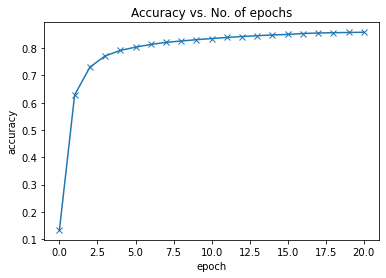

In [54]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

위의 그림에서 보듯이 이 모델은 오랜 시간 학습을 진행한 후에도 정확도가 90%를 넘지 못할 것입니다.<br>
이것에 대한 한 가지 이유는 학습률(learning rate)가 너무 높아서일수 있습니다. <br>
모델의 파라미터는 가장 낮은 손실에 대한 최적의 파라미터를 중심으로 _진동_ 할 수 있습니다.<br>
학습률을 낮추고 몇 epoch 더 학습하여 이것이 개선 될 수 있는지 알아볼 수 있습니다.

더 가능성 있는 이유로는 __모델이 충분히 강력하지 않기 때문__ 일수도 있습니다.<br>
초기 가설을 생각해보면, 출력(위의 경우 클래스별 확률)이 입력(픽셀 강도)의 __선형 함수__ 라고 가정했는데, 가중치 행렬을 사용한 행렬곱을 수행하고 편향을 더함으로써 얻어진 것입니다.<br>
이는 이미지의 픽셀 강도와 픽셀이 나타내는 숫자 사이의 선형 관계가 사실 존재하지 않을 수 있기에 상당히 __약한__ 가정입니다.<br>
MNIST와 같은 단순 데이터셋에는 적합한 가정일 수 있지만, 일상적 물체, 동물 인식과 같은 복잡한 작업을 위해서는 이미지 픽셀과 레이블 사이의 <font color=red>_비선형 관계_</font> 를 파악할 수 있는 __보다 복잡하고 정교한 모델__이 필요합니다.

## 개별 이미지 테스트

지금까지 모델의 전체적인 정확도를 주로 보았지만, _일부 샘플 이미지_ 에서의 모델의 결과를 살펴보는 것도 좋습니다. <br>
사전 정의된 테스트 데이터 세트인 10000개의 영상으로 모델을 테스트해 보겠습니다.<br>
먼저 테스트 데이터 셋을 `ToTensor`변환으로 적용하도록 재생성 합니다.

In [55]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

아래는 데이터 셋의 샘플 이미지 입니다.

Shape: torch.Size([1, 28, 28])
Label: 7


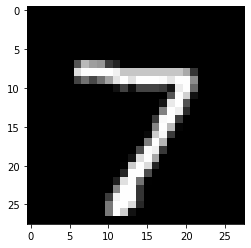

In [56]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

단일 이미지 텐서에 대한 예측 레이블을 반환하는 `predict_image`함수를 정의하겠습니다.

In [57]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

`img.unsqueeze`는 단순히 텐서에 1차원을 더해주는 메서드입니다.<br>
1×28×28인 텐서가 이 메서드를 호출한다면 1×1×28×28 텐서가 되는데, 이 텐서는 모델이 하나의 이미지를 포함한 배치로 간주하게 됩니다.

몇가지 이미지로 실험해 보겠습니다.

Label: 7 , Predicted: 7


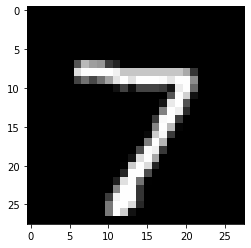

In [58]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 0


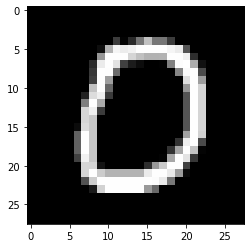

In [59]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


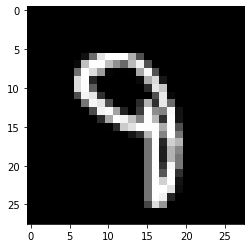

In [60]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 8


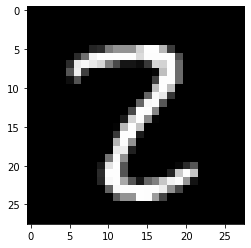

In [61]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

모델이 성능이 떨어지는 부분을 파악한다면, 더 많은 학습 데이터를 수집하고, 모델의 복잡성을 조절하고, 하이퍼 파라미터를 변경하여 모델의 성능을 개선할 수 있습니다.

마지막으로 테스트 셋에서의 모델의 전체 손실과 정확도를 살펴보겠습니다.

In [62]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6380929350852966, 'val_acc': 0.8603515625}

일반적으로 테스트 셋의 정확도와 손실은 검증 셋에서와 비슷할 것으로 예상됩니다.<br>
그렇지 않다면, 테스트 세트와 유사한 데이터와 분포를 가진 더 나은 검증 셋이 필요할 수 있습니다.

## 모델을 저장하고 불러오기

오랜 시간 모델을 학습하여 이상적인 정확도를 달성하였습니다.<br>
이 모델의 가중치와 편향 행렬을 <font color=blue>저장</font>하면 나중에 모델이 필요할때 모델을 처음부터 재학습 하지 않고 기존에 학습한 모델을 불러와 __재사용__ 할 수 있으므로 좋습니다.<br>
모델을 저장 할 수 있는 방법은 아래 코드와 같습니다.

In [63]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

`.state_dict` 메서드는 모델의 모든 가중치와 편향 행렬이 포함된 `OrderedDict`를 반환합니다.

In [64]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0176,  0.0144,  0.0112,  ...,  0.0134,  0.0029,  0.0324],
                      [-0.0102, -0.0232, -0.0354,  ...,  0.0244, -0.0123, -0.0059],
                      [-0.0017,  0.0203,  0.0146,  ..., -0.0045, -0.0304,  0.0138],
                      ...,
                      [-0.0238,  0.0045,  0.0163,  ...,  0.0154,  0.0211,  0.0009],
                      [ 0.0116,  0.0326, -0.0194,  ..., -0.0031,  0.0184,  0.0112],
                      [-0.0045,  0.0016, -0.0295,  ..., -0.0191, -0.0221, -0.0105]])),
             ('linear.bias',
              tensor([-0.0552,  0.1183, -0.0205, -0.0539,  0.0573,  0.0443, -0.0077,  0.0541,
                      -0.0644,  0.0077]))])

`MnistModel`클래스의 새로운 객체를 만들고, `.load_state_dict` 메서드를 사용해 __모델의 가중치__ 를 불러올 수 있습니다.

In [65]:
model2 = MnistModel()

In [66]:
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0160,  0.0317, -0.0253,  ...,  0.0291, -0.0258, -0.0033],
                      [ 0.0155, -0.0054,  0.0304,  ...,  0.0024,  0.0128,  0.0070],
                      [ 0.0180,  0.0040, -0.0251,  ...,  0.0138, -0.0324, -0.0225],
                      ...,
                      [ 0.0274, -0.0110,  0.0145,  ..., -0.0199, -0.0343,  0.0060],
                      [-0.0335, -0.0146,  0.0303,  ...,  0.0131,  0.0196,  0.0280],
                      [ 0.0159,  0.0194, -0.0097,  ...,  0.0023,  0.0079, -0.0274]])),
             ('linear.bias',
              tensor([ 0.0164, -0.0153,  0.0047,  0.0129, -0.0103, -0.0190,  0.0243,  0.0111,
                       0.0300,  0.0244]))])

In [67]:
evaluate(model2, test_loader)

{'val_loss': 2.346466064453125, 'val_acc': 0.09160156548023224}

In [68]:
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0176,  0.0144,  0.0112,  ...,  0.0134,  0.0029,  0.0324],
                      [-0.0102, -0.0232, -0.0354,  ...,  0.0244, -0.0123, -0.0059],
                      [-0.0017,  0.0203,  0.0146,  ..., -0.0045, -0.0304,  0.0138],
                      ...,
                      [-0.0238,  0.0045,  0.0163,  ...,  0.0154,  0.0211,  0.0009],
                      [ 0.0116,  0.0326, -0.0194,  ..., -0.0031,  0.0184,  0.0112],
                      [-0.0045,  0.0016, -0.0295,  ..., -0.0191, -0.0221, -0.0105]])),
             ('linear.bias',
              tensor([-0.0552,  0.1183, -0.0205, -0.0539,  0.0573,  0.0443, -0.0077,  0.0541,
                      -0.0644,  0.0077]))])

안전성 검사때와 마찬가지로, 모델이 테스트 셋에 이전과 같은 손실과 정확성을 갖는지 확인해 보겠습니다.

In [69]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_loss': 0.6380929350852966, 'val_acc': 0.8603515625}

## 연습 과제

짧은 시간 내에 훌륭한 기계 학습 모델을 교육하려면 여러번의 연습과 많은 경험이 필요합니다. <br>
다양한 데이터셋, 모델 및 하이퍼 파라미터로 실험해 보는것이 이 기술을 습득하는 가장 좋은 방법입니다.

## 요약과 더 읽을 거리

이번 튜토리얼에서는 상당히 정교한 교육 및 평가 파이프라인을 만들었습니다. <br>
다음은 이번 튜토리얼에서 다룬 주제 목록입니다:

* PyTorch에서의 이미지 작업(MNIST 데이터셋을 사용)
* 교육, 검증 및 테스트 세트로 데이터셋 분할
* `nn.Module`을 상속해 커스텀 로직 PyTorch 모델 클래스
* Softmax를 사용하여 모델 출력을 확률로 해석 및 예측 레이블 선택
* 분류문제의 평가지표(정확도) 및 손실함수(크로스 엔트로피) 선정
* 검증 셋을 사용하여 모델을 평가하는 학습 루프 설정
* 무작위로 선택한 예제에 대해 수동으로 모델 테스트
* 모델 체크포인트 저장 및 로딩으로 처음부터 재교육 방지


이 튜토리얼에는 아직 하지 않은 많은 실험들이 있습니다. <br>
따라서 주피터의 상호작용 특성을 활용하여 다양한 매개 변수를 활용할 것을 권장합니다. 다음은 몇 가지 아이디어입니다:

* 검증 셋을 더 작거나 크게 만든 후 모델에 어떤 영향을 미치는지 확인하기
* 학습률을 변경하여 더 적은 시간에 동일한 정확도를 달성할 수 있는지 확인하기
* 배치 크기를 변경 후 배치 크기가 너무 크거나 너무 작으면 어떻게 되는지 알아보기.
* `fit` 기능을 수정하여 학습 셋의 전체적인 손실과 정확성을 기록하고, 검증 손실/정확도와 비교. 낮은/높은 이유를 설명해보기.
* 데이터의 작은 서브셋으로 교육하여 비슷한 수준의 정확도를 얻을 수 있는지 확인해보기.
* [CIFAR10 또는 CIFAR100 데이터셋](https://www.cs.toronto.edu/~kriz/cifar.complete)과 같은 다른 데이터셋에 대한 모델을 구축해 보기.